In [1]:
import Data_acq as data
from models import Encoder
from models import Decoder
from models import cVAE
import matplotlib.pyplot as plt
import importlib

Datos

In [2]:
import importlib
importlib.reload(data)
x_train, x_test,x_val ,y_train, y_test,y_val, x_train_1, y_train_1 = data.get_mnist_data()




Usando mnist como dataset


Enconder decoder


(1, 784)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
[[-0.30174956 -0.20360665]]
[[-0.13641241  0.44225055]]
[[0.26972774 1.5116383 ]]
(784,)


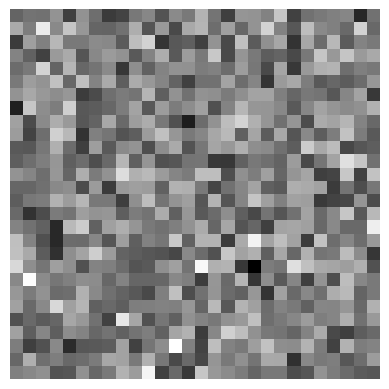

In [3]:
import importlib
import numpy as np
importlib.reload(Encoder)
importlib.reload(Decoder)

#img_dim=(28,28),condition_dim=(10,),intermediate_dim=128,latent_dim=2
#latent_dim=2, cond_dim=(10,), intermediate_dim=128, original_shape=(28, 28)

en = Encoder.build_enconder(intermediate_dim=128,latent_dim=2)
de = Decoder.build_decoder(intermediate_dim=128,latent_dim=2)


img_sample = np.expand_dims(x_train[0], axis=0)# shape (1, 28, 28)
cond_sample = np.expand_dims(y_train[0], axis=0) 
print(img_sample.shape)
[z, z_mean, z_log_var] = en.predict([img_sample,cond_sample])

img_recons = de.predict([z,cond_sample])

print(z)
print(z_mean)
print(z_log_var)
print(img_recons[0].shape)

plt.imshow(img_recons[0].reshape(28, 28), cmap="gray")
plt.axis("off")
plt.show()


In [4]:
import tensorflow as tf
from keras.callbacks import EarlyStopping

importlib.reload(cVAE)
original_dim = 28*28
beta = 1.0

train_dataset = tf.data.Dataset.from_tensor_slices(((x_train, y_train), x_train))
#train_dataset = train_dataset.shuffle(buffer_size=1024).batch(128)
train_dataset = train_dataset.batch(128)

early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=3,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

val_dataset = tf.data.Dataset.from_tensor_slices(((x_val, y_val), x_val))
val_dataset = val_dataset.batch(128)


cvae = cVAE.CVAE(encoder=en, decoder=de, original_dim=original_dim, beta=1)
cvae.compile(optimizer=tf.keras.optimizers.Adam())



In [5]:
cvae.fit(train_dataset,
        epochs=10,
        batch_size=128,
        validation_data=val_dataset,
        callbacks=[early_stopping]
         )

Epoch 1/10
430/430 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - kl_loss: 6.1773 - loss: 77.8887 - reconstruction_loss: 71.7115 - val_kl_loss: 2.0176 - val_loss: 39.8774 - val_reconstruction_loss: 37.9038
Epoch 2/10
430/430 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - kl_loss: 1.9617 - loss: 39.8825 - reconstruction_loss: 37.9208 - val_kl_loss: 2.0246 - val_loss: 37.0274 - val_reconstruction_loss: 35.0543
Epoch 3/10
430/430 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - kl_loss: 2.0592 - loss: 37.7355 - reconstruction_loss: 35.6763 - val_kl_loss: 2.0157 - val_loss: 35.7071 - val_reconstruction_loss: 33.7883
Epoch 4/10
430/430 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - kl_loss: 2.2052 - loss: 36.4370 - reconstruction_loss: 34.2318 - val_kl_loss: 2.3676 - val_loss: 34.9039 - val_reconstruction_loss: 32.6182
Epoch 5/10
430/430 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - kl_loss: 2.3577 - loss: 35.6147 - reconstruction_loss: 33.2570 - val_kl_loss: 2.3520 - val_loss: 34.2656 - val_reconstruction_loss: 31.9846
Epoch 6/10
430/430 ━━━━━━━━━━━

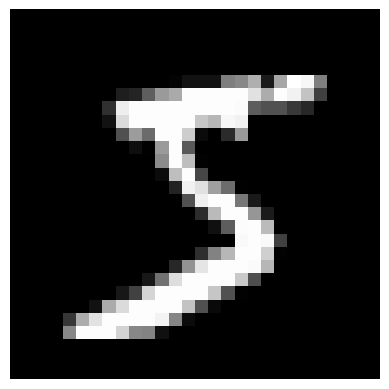

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
(1, 784)


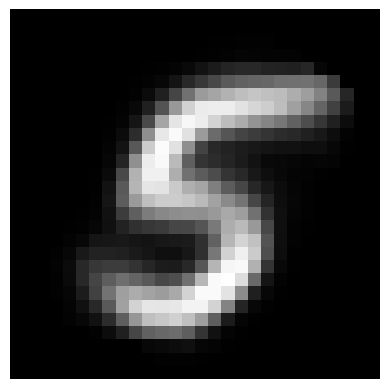

In [6]:
x_input = x_train[:1]         # 1 imagen (shape: (1, 28, 28))
cond_input = y_train[:1]      # su condición (shape: (1, 10))

plt.imshow(x_input[0].reshape(28, 28), cmap="gray")
plt.axis("off")
plt.show()

z_mean, z_log_var, z = cvae.encoder.predict([x_input, cond_input])

# Paso por el decoder para reconstrucción
reconstructed = cvae.decoder.predict([z, cond_input])
print(reconstructed.shape)
plt.imshow(reconstructed[0].reshape(28, 28), cmap="gray")
plt.axis("off")
plt.show()

In [7]:
'''
# Tomá una imagen del conjunto de test
indices_de_testeo=[1, 3, 5, 7, 2, 0, 13, 15, 17, 4] # inidices donde para que x_train[inidicies] sea 0 1 2 3 4 5 6 7 8 9 0

for i in indices_de_testeo:

    imagen = x_train[i]
    #plt.imshow(imagen)
    #plt.show()
    # Visualizá cómo se reconstruye con todas las condiciones posibles
    vis.condiciones(cvae, imagen)
# Ver 10 variantes generadas para la clase 3
for i in range(10):
    
    vis.variantes(cvae, condicion_id=i, num_variantes=10)
'''

'\n# Tomá una imagen del conjunto de test\nindices_de_testeo=[1, 3, 5, 7, 2, 0, 13, 15, 17, 4] # inidices donde para que x_train[inidicies] sea 0 1 2 3 4 5 6 7 8 9 0\n\nfor i in indices_de_testeo:\n\n    imagen = x_train[i]\n    #plt.imshow(imagen)\n    #plt.show()\n    # Visualizá cómo se reconstruye con todas las condiciones posibles\n    vis.condiciones(cvae, imagen)\n# Ver 10 variantes generadas para la clase 3\nfor i in range(10):\n    \n    vis.variantes(cvae, condicion_id=i, num_variantes=10)\n'

# Predictores

In [8]:
import models.Predictor as predictores
importlib.reload(predictores)

predictor = predictores.build_predictor() 

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

predictor.compile(optimizer, loss="categorical_crossentropy")

#x_rain_conv = np.reshape(x_train,(28,28,1)) 
predictor.fit(
    x=x_train,
    y=y_train,
    batch_size=128,
    epochs=5,
    validation_data=(x_val, y_val)  # Include validation data
#    callbacks=[cp_callback_predictor_C2, early_stopping]  # Add early_stopping to callbacks
)

Model: "predictor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ original_input (InputLayer)     │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_layer (ReshapeLayer)    │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 14, 14, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 14, 14, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 7, 7, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │        31,370 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,570 (197.54 KB)

 Trainable params: 50,378 (196.79 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/5
430/430 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - loss: 0.5989 - val_loss: 0.3647
Epoch 2/5
430/430 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - loss: 0.1127 - val_loss: 0.0575
Epoch 3/5
430/430 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - loss: 0.0893 - val_loss: 0.0582
Epoch 4/5
430/430 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - loss: 0.0715 - val_loss: 0.0455
Epoch 5/5
430/430 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - loss: 0.0627 - val_loss: 0.0495


(784,)


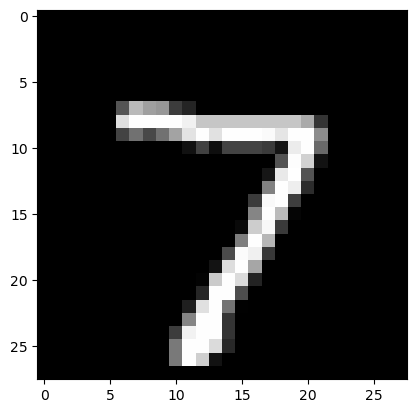

dentro del loop
(784,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
Digito predicho: 7


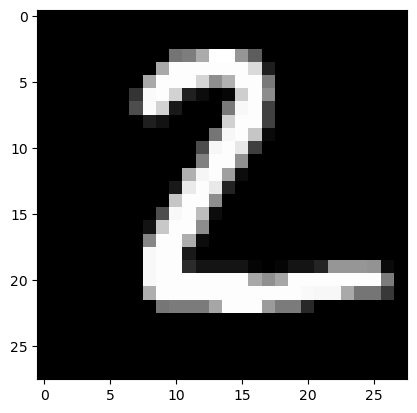

dentro del loop
(784,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Digito predicho: 2


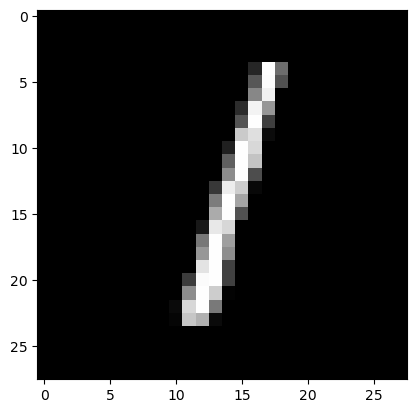

dentro del loop
(784,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Digito predicho: 1


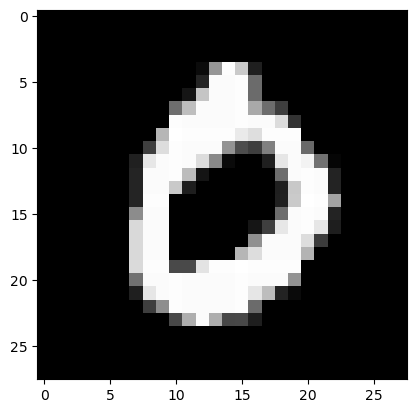

dentro del loop
(784,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Digito predicho: 0


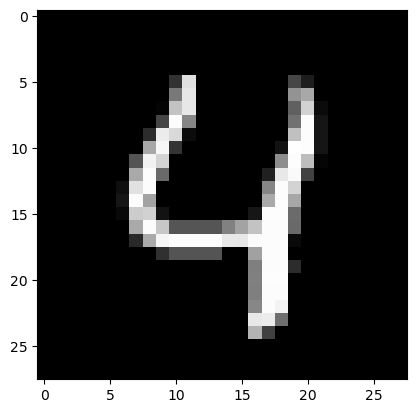

dentro del loop
(784,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Digito predicho: 4


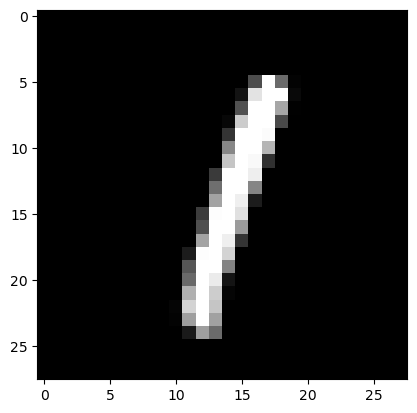

dentro del loop
(784,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Digito predicho: 1


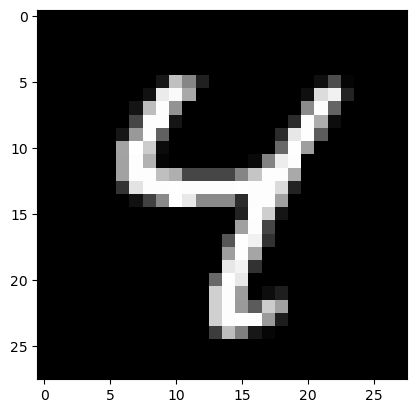

dentro del loop
(784,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Digito predicho: 4


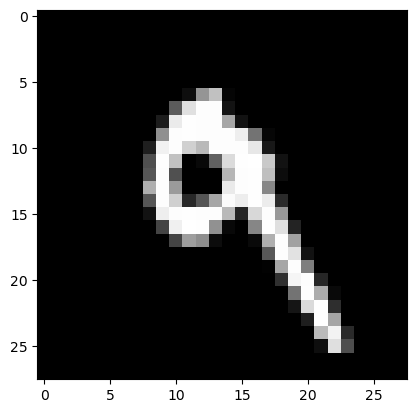

dentro del loop
(784,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Digito predicho: 9


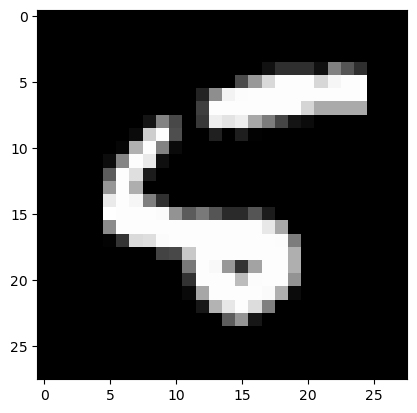

dentro del loop
(784,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Digito predicho: 6


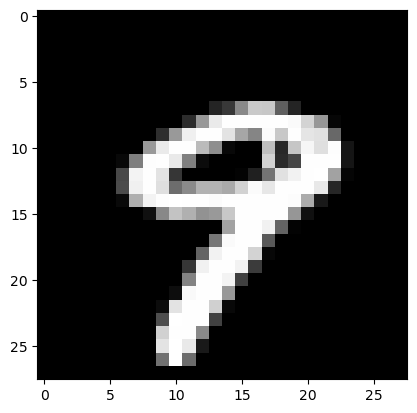

dentro del loop
(784,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Digito predicho: 9


In [9]:
print(x_test[0].shape)
for i in range(10):
    plt.imshow(x_test[i].reshape(28, 28),cmap="gray")
    plt.show()
    print("dentro del loop")
    print(x_test[i].shape)
    print(f"Digito predicho: {np.argmax( predictor.predict(x_test[i].reshape(1, 784)))}")

# Pruebas de separacion de digitos


Shape de x_train
(10, 784)
ITERACIÓN A:  0
ITERACIÓN A:  1
ITERACIÓN A:  2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
select_1:       tf.Tensor([0 1 0 0 1 1 0 1 0 1], shape=(10,), dtype=int64)
select_1_1:     tf.Tensor([0 0 1 1 0 1 1 0 1 0], shape=(10,), dtype=int64)
################################################################################################
formas de x y select_1 

(10, 784)
(10, 784)
(10, 1)
(10, 1)
################################################################################################
y_reduced:    tf.Tensor([5 0 4 1 9 2 1 3 1 4], shape=(10,), dtype=int64)
y_1_reduced:  tf.Tensor([1 3 9 4 1 2 3 7 9 9], shape=(10,), dtype=int64)
y_s1:          tf.Tensor([0 0 0 0 9 2 0 3 0 4], shape=(10,), dtype=int

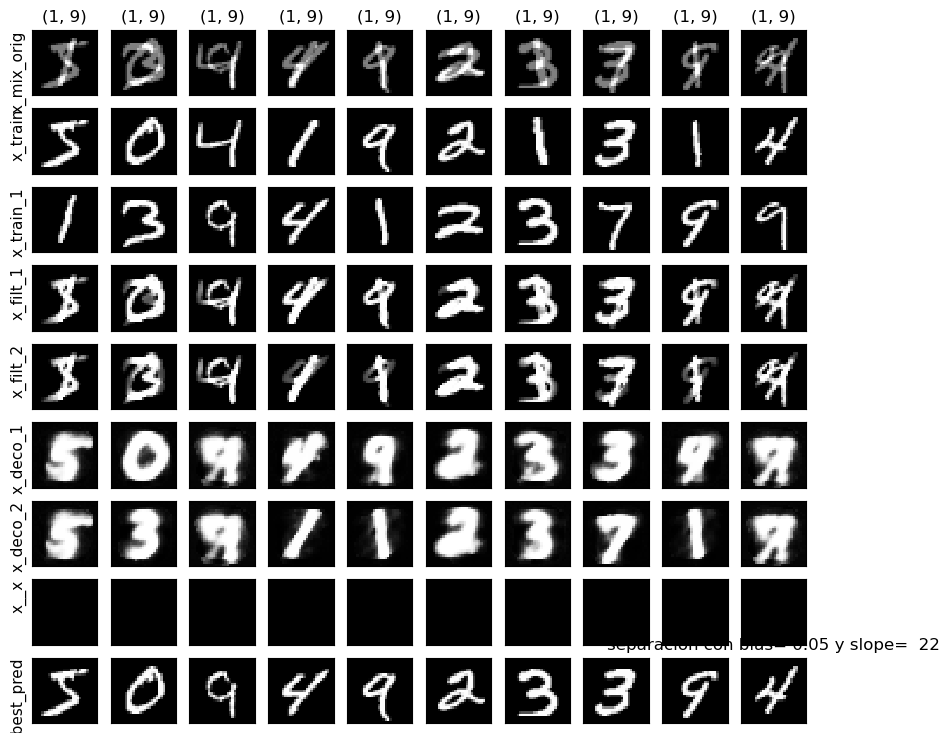

Fig.: En la primera fila se observan las imágenes de TRAIN superpuestas, las componentes en las dos siguientes,
      la reconstrucción final en la cuarta, la mejor imagen original basada en MSE en la quinta y en la última
      la mejor imagen según la predicción.
Shape de x_train
(10, 784)
ITERACIÓN A:  0
ITERACIÓN A:  1
ITERACIÓN A:  2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
select_1:       tf.Tensor([0 1 0 0 1 1 0 1 0 0], shape=(10,), dtype=int64)
select_1_1:     tf.Tensor([0 0 1 1 0 1 1 0 1 0], shape=(10,), dtype=int64)
################################################################################################
formas de x y select_1 

(10, 784)
(10, 784)
(10, 1)
(10, 1)
###############################################

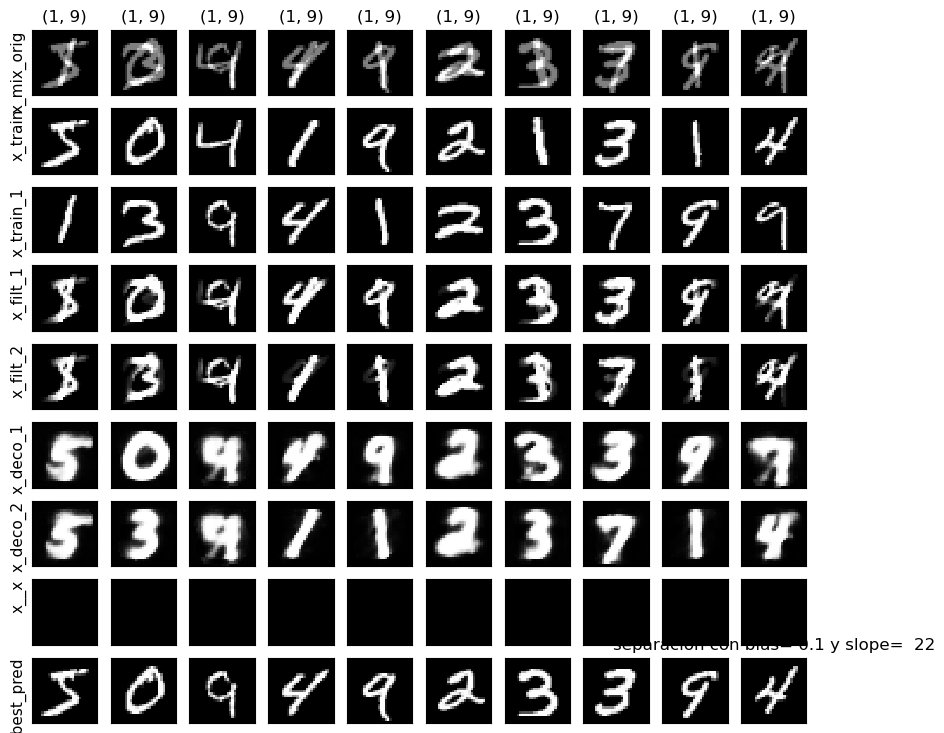

Fig.: En la primera fila se observan las imágenes de TRAIN superpuestas, las componentes en las dos siguientes,
      la reconstrucción final en la cuarta, la mejor imagen original basada en MSE en la quinta y en la última
      la mejor imagen según la predicción.
Shape de x_train
(10, 784)
ITERACIÓN A:  0
ITERACIÓN A:  1
ITERACIÓN A:  2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
select_1:       tf.Tensor([0 1 0 0 1 1 0 1 0 1], shape=(10,), dtype=int64)
select_1_1:     tf.Tensor([0 0 1 1 0 1 1 0 1 0], shape=(10,), dtype=int64)
################################################################################################
formas de x y select_1 

(10, 784)
(10, 784)
(10, 1)
(10, 1)
###############################################

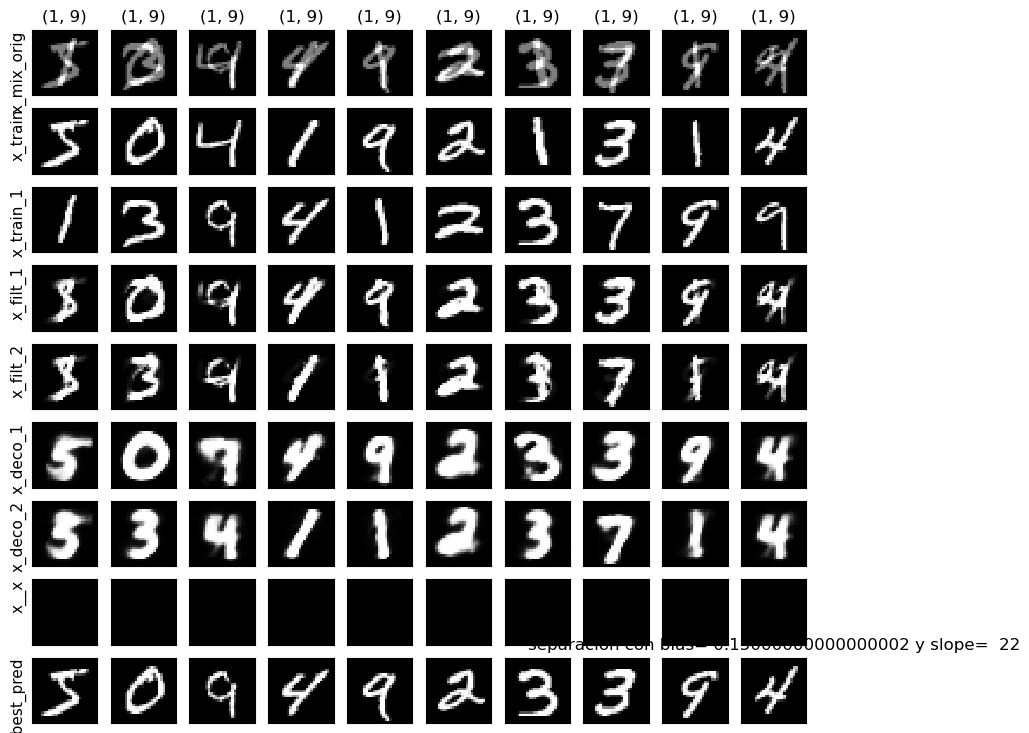

Fig.: En la primera fila se observan las imágenes de TRAIN superpuestas, las componentes en las dos siguientes,
      la reconstrucción final en la cuarta, la mejor imagen original basada en MSE en la quinta y en la última
      la mejor imagen según la predicción.
Shape de x_train
(10, 784)
ITERACIÓN A:  0
ITERACIÓN A:  1
ITERACIÓN A:  2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
select_1:       tf.Tensor([0 1 1 0 1 1 0 1 0 1], shape=(10,), dtype=int64)
select_1_1:     tf.Tensor([0 0 0 1 0 1 1 0 1 0], shape=(10,), dtype=int64)
################################################################################################
formas de x y select_1 

(10, 784)
(10, 784)
(10, 1)
(10, 1)
###############################################

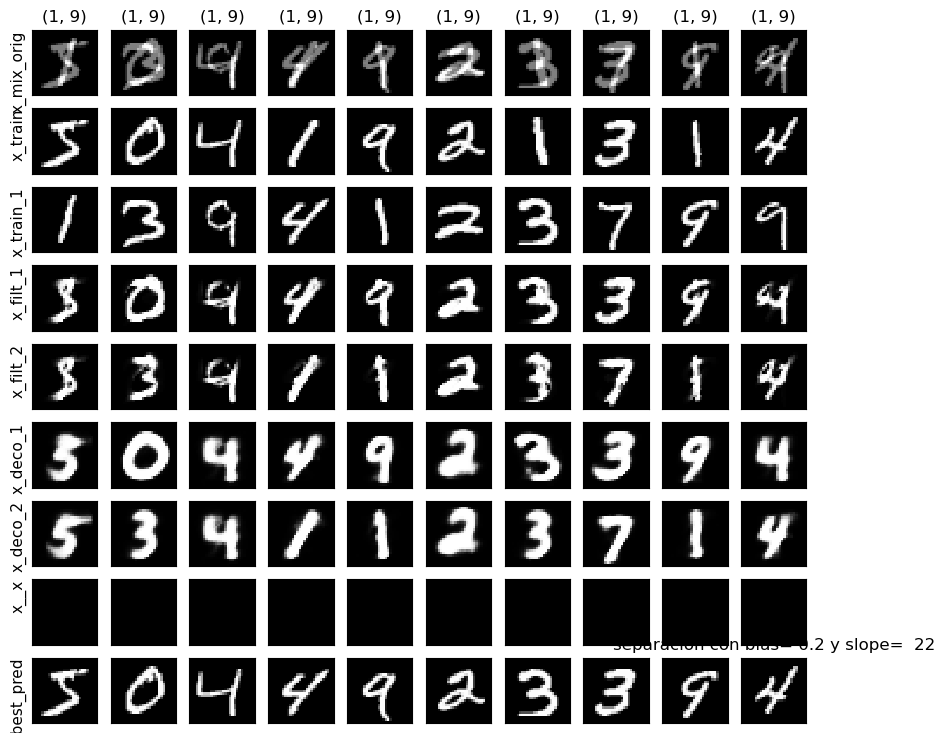

Fig.: En la primera fila se observan las imágenes de TRAIN superpuestas, las componentes en las dos siguientes,
      la reconstrucción final en la cuarta, la mejor imagen original basada en MSE en la quinta y en la última
      la mejor imagen según la predicción.
Shape de x_train
(10, 784)
ITERACIÓN A:  0
ITERACIÓN A:  1
ITERACIÓN A:  2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
select_1:       tf.Tensor([0 1 1 0 1 1 0 1 0 1], shape=(10,), dtype=int64)
select_1_1:     tf.Tensor([0 0 0 1 0 1 1 0 1 0], shape=(10,), dtype=int64)
################################################################################################
formas de x y select_1 

(10, 784)
(10, 784)
(10, 1)
(10, 1)
###############################################

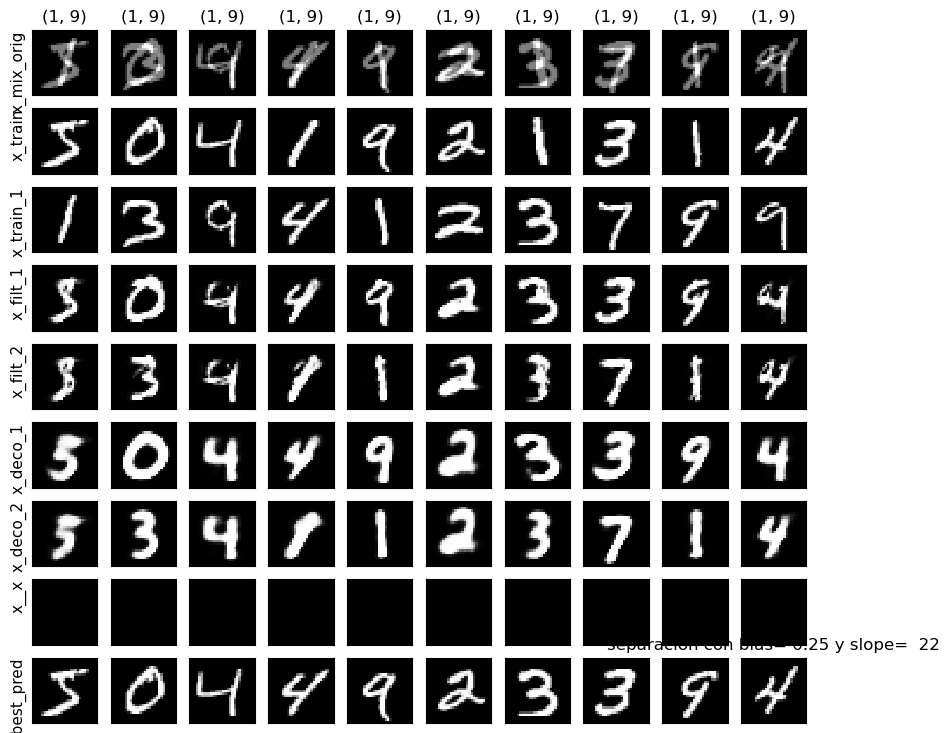

Fig.: En la primera fila se observan las imágenes de TRAIN superpuestas, las componentes en las dos siguientes,
      la reconstrucción final en la cuarta, la mejor imagen original basada en MSE en la quinta y en la última
      la mejor imagen según la predicción.


In [ ]:
import inferencias.inferencia as inf
import importlib
importlib.reload(inf)


for i in range(5):

    inf.separar_digitos(x_train[0:10],x_train_1[0:10],y_train[0:10],y_train_1[0:10],en,de,predictor,bias=0.05*(i+1))